In [187]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [189]:
data = pd.read_csv("data/airplane/airplane_price_dataset.csv")
data.head()

,Model,Üretim Yılı,Motor Sayısı,Motor Türü,Kapasite,Menzil (km),Yakıt Tüketimi (L/saat),Saatlik Bakım Maliyeti ($),Yaş,Satış Bölgesi,Fiyat ($)
0,Bombardier CRJ200,1987,2,Turbofan,50,3000,14.36,2185.43,36,Asya,1.285708e+07
1,Bombardier CRJ200,1997,2,Turbofan,50,3000,4.03,1202.08,26,Avrupa,1.391406e+07
2,Airbus A320,1988,2,Turbofan,180,6300,13.26,761.38,35,Avustralya,9.073570e+07
3,Boeing 737,2023,2,Turbofan,162,5700,14.61,592.63,0,Avustralya,1.366597e+08
4,Cessna 172,1985,1,Piston,4,1285,18.49,4245.99,38,Güney Amerika,2.037981e+05


Voici une description de chaque colonne du dataset ainsi qu'une proposition de renommage en français pour une meilleure lisibilité :  

### **Description des colonnes :**  
1. **Model** → *Modèle* : Le nom du modèle d'avion.  
2. **Üretim Yılı** → *Année de production* : L'année de fabrication de l'avion.  
3. **Motor Sayısı** → *Nombre de moteurs* : Le nombre total de moteurs équipant l'avion.  
4. **Motor Türü** → *Type de moteur* : Le type de moteur utilisé (ex. : Turbofan, Turboprop, etc.).  
5. **Kapasite** → *Capacité* : Le nombre maximal de passagers que l'avion peut transporter.  
6. **Menzil (km)** → *Autonomie (km)* : La distance maximale que l'avion peut parcourir sans ravitaillement en carburant (en kilomètres).  
7. **Yakıt Tüketimi (L/saat)** → *Consommation de carburant (L/h)* : La quantité de carburant consommée par heure de vol (en litres par heure).  
8. **Saatlik Bakım Maliyeti ($)** → *Coût de maintenance horaire ($)* : Le coût moyen d'entretien de l'avion par heure de vol (en dollars).  
9. **Yaş** → *Âge* : L'âge de l'avion en années.  
10. **Satış Bölgesi** → *Région de vente* : La région où l'avion est vendu (ex. : Asie, Europe, etc.).  
11. **Fiyat ($)** → *Prix ($)* : Le prix de vente de l'avion en dollars.  

# 1. Compréhension et Préparation des Données
Avant tout, il est important d'explorer le dataset pour identifier d'éventuelles valeurs manquantes, outliers ou incohérences. Ici, nous allons supposer que le dataset est propre.
Nous devons aussi distinguer les variables numériques des variables catégorielles.

**Variables numériques** :

- Année de production
- Nombre de moteurs
- Capacité
- Autonomie (km)
- Consommation de carburant (L/h)
- Coût de maintenance horaire ($)
- Âge


**Variables catégorielles** :

- Modèle
- Type de moteur
- Région de vente

**La variable cible sera Prix ($).**

In [193]:
# renommage des colonnes
data.rename(columns={
    "Model": "Modèle",
    "Üretim Yılı": "Année de production",
    "Motor Sayısı": "Nombre de moteurs",
    "Motor Türü": "Type de moteur",
    "Kapasite": "Capacité",
    "Menzil (km)": "Autonomie (km)",
    "Yakıt Tüketimi (L/saat)": "Consommation de carburant (L/h)",
    "Saatlik Bakım Maliyeti ($)": "Coût de maintenance horaire ($)",
    "Yaş": "Âge",
    "Satış Bölgesi": "Région de vente",
    "Fiyat ($)": "Prix ($)"
}, inplace=True)

# Vérification des noms de colonnes
print("Colonnes du DataFrame :", data.columns.tolist())

Colonnes du DataFrame : ['Modèle', 'Année de production', 'Nombre de moteurs', 'Type de moteur', 'Capacité', 'Autonomie (km)', 'Consommation de carburant (L/h)', 'Coût de maintenance horaire ($)', 'Âge', 'Région de vente', 'Prix ($)']


In [195]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12377 entries, 0 to 12376
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Modèle                           12377 non-null  object 
 1   Année de production              12377 non-null  int64  
 2   Nombre de moteurs                12377 non-null  int64  
 3   Type de moteur                   12377 non-null  object 
 4   Capacité                         12377 non-null  int64  
 5   Autonomie (km)                   12377 non-null  int64  
 6   Consommation de carburant (L/h)  12377 non-null  float64
 7   Coût de maintenance horaire ($)  12377 non-null  float64
 8   Âge                              12377 non-null  int64  
 9   Région de vente                  12377 non-null  object 
 10  Prix ($)                         12377 non-null  float64
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ MB


In [197]:
data.describe()

,Année de production,Nombre de moteurs,Capacité,Autonomie (km),Consommation de carburant (L/h),Coût de maintenance horaire ($),Âge,Prix ($)
count,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,12377.000000,1.237700e+04
mean,2001.477660,1.835259,190.413994,7782.210148,12.075615,2744.089599,21.522340,1.988336e+08
std,12.766785,0.370962,142.662710,5492.478746,9.905418,1293.209611,12.766785,2.290392e+08
min,1980.000000,1.000000,4.000000,1285.000000,2.000000,500.020000,0.000000,1.458148e+05
25%,1990.000000,2.000000,50.000000,3000.000000,5.950000,1627.260000,10.000000,1.409681e+07
50%,2001.000000,2.000000,162.000000,5700.000000,9.820000,2744.330000,22.000000,8.392191e+07
75%,2013.000000,2.000000,350.000000,14800.000000,13.470000,3848.840000,33.000000,3.843239e+08
max,2023.000000,2.000000,396.000000,15600.000000,49.970000,4999.660000,43.000000,9.782132e+08


In [199]:
data.duplicated().sum()

0

In [201]:
# Détection des valeurs aberrantes avec l'IQR
def detect_outliers_iqr(df):
    outliers = {}
    for col in df.select_dtypes(include=['number']).columns:  # Vérifie seulement les colonnes numériques
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    return outliers

outliers_iqr = detect_outliers_iqr(data)

# Affichage des valeurs aberrantes par colonne
for col, outlier_values in outliers_iqr.items():
    print(f"Valeurs aberrantes dans {col} :")
    print(outlier_values)
    print("-" * 50)


Valeurs aberrantes dans Année de production :
Series([], Name: Année de production, dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Nombre de moteurs :
4        1
7        1
8        1
19       1
20       1
        ..
12356    1
12357    1
12360    1
12368    1
12375    1
Name: Nombre de moteurs, Length: 2039, dtype: int64
--------------------------------------------------
Valeurs aberrantes dans Capacité :
Series([], Name: Capacité, dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Autonomie (km) :
Series([], Name: Autonomie (km), dtype: int64)
--------------------------------------------------
Valeurs aberrantes dans Consommation de carburant (L/h) :
8        41.41
19       49.48
29       30.34
43       29.58
62       37.68
         ...  
12330    34.56
12343    27.07
12356    40.42
12360    38.81
12368    43.08
Name: Consommation de carburant (L/h), Length: 1286, dtype: float64
--------------------------

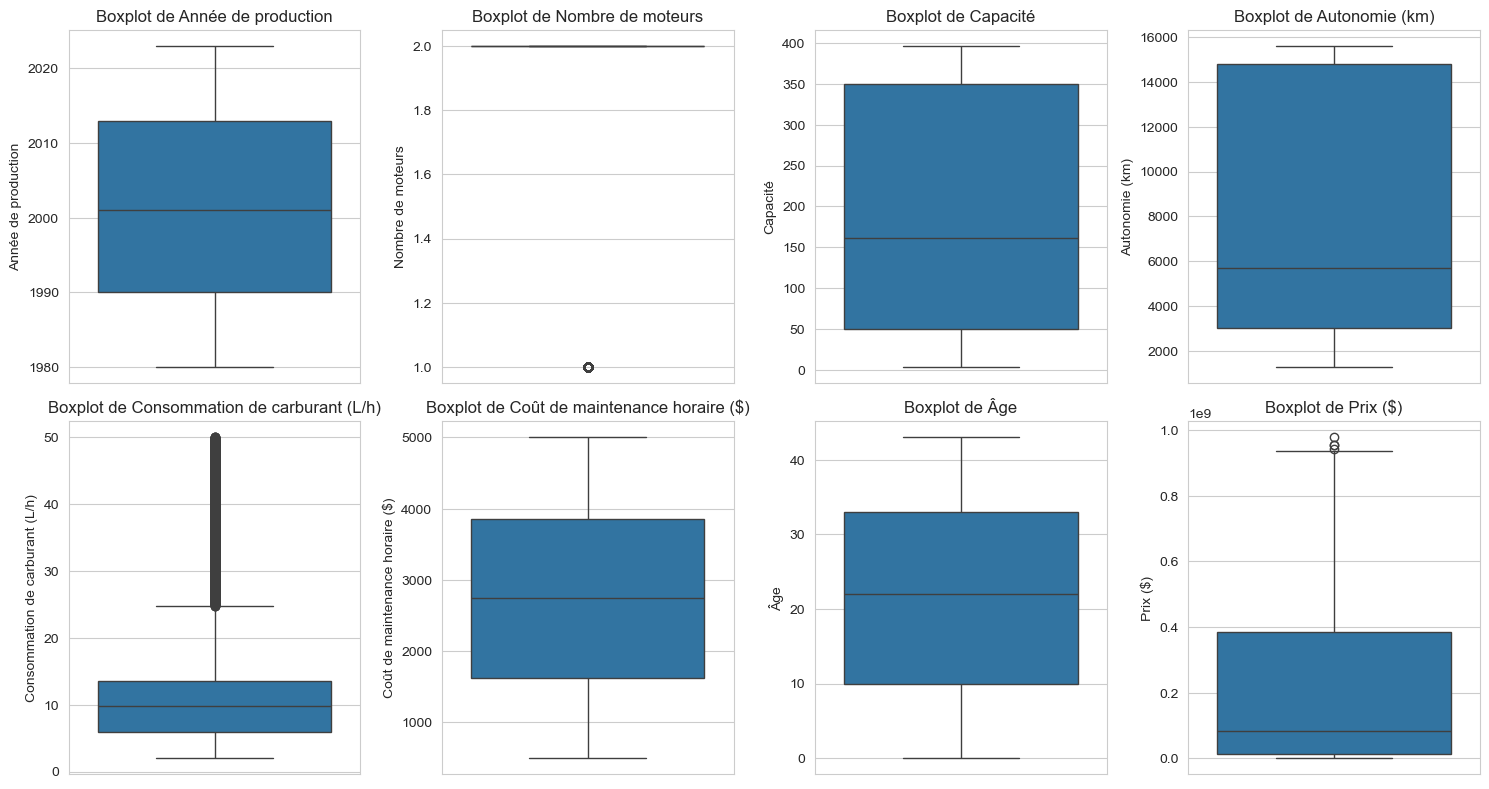

In [203]:
# Configuration des graphiques
plt.figure(figsize=(15, 8))

# Tracer les boxplots pour toutes les colonnes numériques
for i, col in enumerate(data.select_dtypes(include=['number']).columns, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(y=data[col])
    plt.title(f"Boxplot de {col}")

plt.tight_layout()
plt.savefig("boxplots.png")
plt.show()


### **Analyse des Boxplots et Identification des Valeurs Aberrantes**  

En examinant les boxplots, plusieurs observations se dégagent :  

1. **Présence de valeurs aberrantes**  
   - La colonne **Prix ($)** contient des points situés bien au-dessus des moustaches du boxplot, indiquant des prix très élevés considérés comme atypiques.
   - La **consommation de carburant (L/h)** montre aussi des valeurs extrêmes dépassant 30 L/h.
   - Le **coût de maintenance horaire ($)** présente une dispersion importante, avec des valeurs élevées.
   - Le **nombre de moteurs** présente un point en dessous de la moustache inférieure, ce qui pourrait être un avion avec un nombre inhabituel de moteurs.

In [205]:
# from scipy import stats

# # Détection des valeurs aberrantes avec le Z-score
# def detect_outliers_zscore(df, threshold=3):
#     outliers = {}
#     for col in df.select_dtypes(include=['number']).columns:
#         z_scores = stats.zscore(df[col].dropna())  # Calcul du Z-score en excluant les valeurs NaN
#         outliers[col] = df[col][(z_scores > threshold) | (z_scores < -threshold)]
#     return outliers

# outliers_zscore = detect_outliers_zscore(data)

# # Affichage des valeurs aberrantes par colonne
# for col, outlier_values in outliers_zscore.items():
#     print(f"Valeurs aberrantes dans {col} (Z-score) :")
#     print(outlier_values)
#     print("-" * 50)


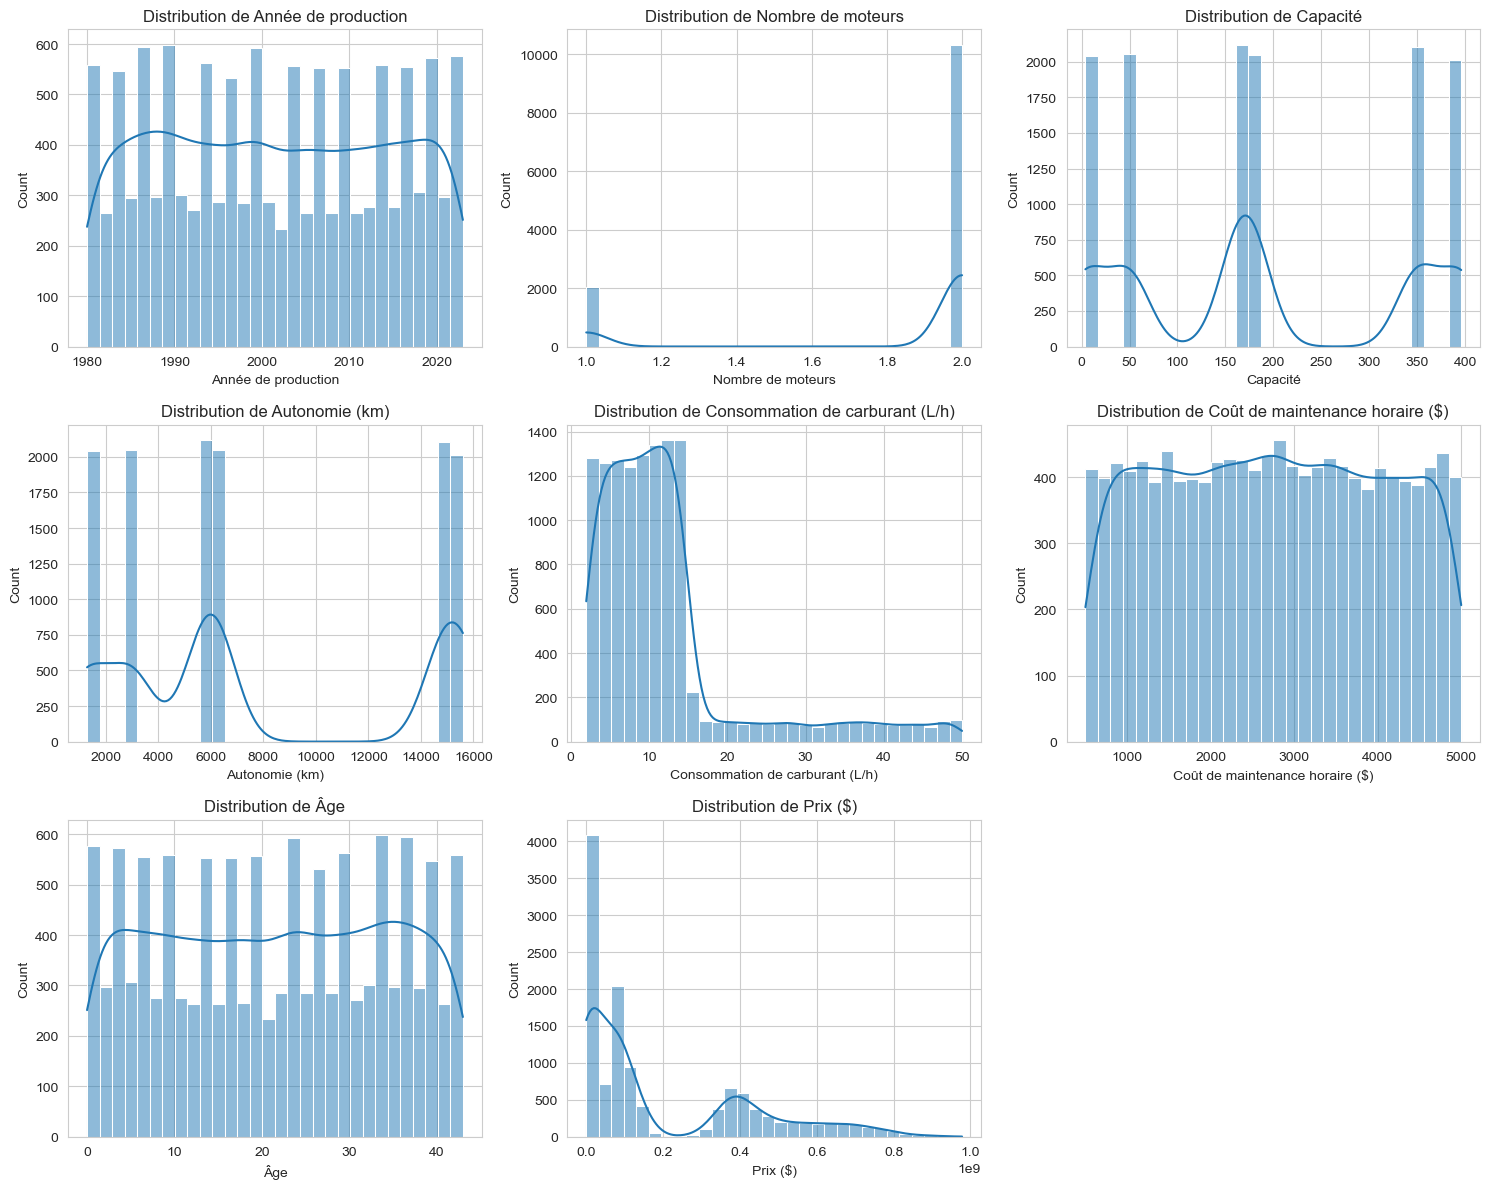

In [206]:
# Sélection des colonnes numériques
numerical_cols = data.select_dtypes(include=['number']).columns

# Configuration du style des graphiques
sns.set_style("whitegrid")

# Création des subplots pour afficher les distributions
fig, axes = plt.subplots(nrows=len(numerical_cols)//3 + 1, ncols=3, figsize=(15, 12))
axes = axes.flatten()

# Générer les distributions pour chaque colonne numérique
for i, col in enumerate(numerical_cols):
    sns.histplot(data[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution de {col}")

# Supprimer les sous-graphiques vides
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("distributions.png")
plt.show()


### **Analyse des distributions :**  
D'après les graphiques, voici quelques observations importantes :

1. **Année de production et Âge**  
   - La répartition est relativement uniforme, ce qui est attendu car les véhicules sont produits sur plusieurs années.  
   - Il n’y a pas de concentration anormale sur une période spécifique.  

2. **Nombre de moteurs**  
   - On observe une **bimodalité** : la plupart des valeurs sont soit **1 moteur**, soit **2 moteurs**, ce qui indique une classification binaire des véhicules.  

3. **Capacité et Autonomie (km)**  
   - Ces variables présentent **des pics nets**, ce qui suggère qu'il existe des catégories bien définies de véhicules avec des capacités standardisées.  

4. **Consommation de carburant (L/h)**  
   - Fortement **asymétrique** et **décroissante** : la majorité des véhicules consomment peu de carburant, mais il existe des cas extrêmes (probablement des valeurs aberrantes).  

5. **Coût de maintenance horaire ($)**  
   - Répartition **quasi-uniforme**, ce qui laisse penser que les coûts sont bien répartis.  

6. **Prix ($)**  
   - **Distribution très asymétrique** avec une longue queue vers la droite, indiquant la présence de **véhicules très chers** qui pourraient être des outliers ou des moteurs tres couteux.  

In [247]:
def engineer_features(data):
    df = data.copy()
    
    # Transformation logarithmique des variables à forte asymétrie
    df['log_Prix'] = np.log1p(df['Prix ($)'])
    df['log_Consommation'] = np.log1p(df['Consommation de carburant (L/h)'])
    df['log_Cout_Maintenance'] = np.log1p(df['Coût de maintenance horaire ($)'])
    
    # Ratios importants
    df['Prix_par_siege'] = df['Prix ($)'] / df['Capacité']
    df['Efficacite'] = df['Autonomie (km)'] / df['Consommation de carburant (L/h)']
    
    return df

# Application du feature engineering
data_engineered = engineer_features(data)

# Préparation des features
numerical_features = [
    'Année de production',
    'Nombre de moteurs',
    'Capacité',
    'Autonomie (km)',
    'log_Consommation',
    'log_Cout_Maintenance',
    'Âge',
    'Prix_par_siege',
    'Efficacite'
]

categorical_features = [
    'Modèle',
    'Type de moteur',
    'Région de vente',
    'Catégorie_Capacité'
]

# Préparation des données
X = data_engineered.drop(['Prix ($)', 'log_Prix', 'Consommation de carburant (L/h)', 'Coût de maintenance horaire ($)'], axis=1)
y = data_engineered['Prix ($)']

# Split des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
    ])

# Modèle XGBoost avec paramètres optimisés
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=1,
    gamma=0.1,
    reg_alpha=0.1,
    reg_lambda=1,
    random_state=42
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', xgb_model)
])

# Recherche d'hyperparamètres fine
param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [5, 6, 7],
    'regressor__learning_rate': [0.03, 0.05],
    'regressor__subsample': [0.8, 0.85],
    'regressor__colsample_bytree': [0.8, 0.85]
}

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X_train, y_train)

# Prédiction et évaluation
y_pred = grid_search.predict(X_test)

# Calcul des métriques
results = {
    'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
    'R²': r2_score(y_test, y_pred),
    'MAE': mean_absolute_error(y_test, y_pred),
    'MAPE': mean_absolute_percentage_error(y_test, y_pred) * 100
}

# Affichage des résultats
print("\nMeilleurs paramètres:", grid_search.best_params_)
print("\nMétriques d'évaluation:")
for metric, value in results.items():
    print(f"{metric}: {value:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Meilleurs paramètres: {'regressor__colsample_bytree': 0.85, 'regressor__learning_rate': 0.03, 'regressor__max_depth': 5, 'regressor__n_estimators': 300, 'regressor__subsample': 0.8}

Métriques d'évaluation:
RMSE: 2923850.8046
R²: 0.9998
MAE: 1054933.9887
MAPE: 6.2133


In [249]:
import joblib

# On sauvegarde le meilleur modèle (pipeline complet) dans un fichier .pkl
joblib.dump(grid_search.best_estimator_, "xgb_airplane_price_model.pkl")

print("Modèle sauvegardé sous 'xgb_airplane_price_model.pkl'")

Modèle sauvegardé sous 'xgb_airplane_price_model.pkl'


### Analyse des résultats

1. **RMSE (Root Mean Square Error) = 2,923,850.80$**
   - Cet indicateur pénalise les erreurs importantes car elles sont élevées au carré
   - Une RMSE de ~2.9M$ pour des avions dont les prix peuvent atteindre plusieurs centaines de millions est très bonne
   - Cela indique que le modèle gère bien les valeurs extrêmes

2. **R² (Coefficient de détermination) = 0.9998**
   - Un R² de 0.9998 signifie que 99.98% de la variance des prix est expliquée par notre modèle
   - C'est un score exceptionnellement élevé, proche de la perfection
   - Cela montre que les variables sélectionnées capturent presque parfaitement les facteurs qui influencent le prix

3. **MAE (Mean Absolute Error) = 1,054,933.99$**
   - En moyenne, notre modèle fait une erreur d'environ 1M$
   - Cette métrique est plus intuitive que la RMSE car elle n'est pas au carré
   - Pour le marché des avions, une erreur moyenne de 1M$ est très faible

4. **MAPE (Mean Absolute Percentage Error) = 6.21%**
   - En termes relatifs, notre modèle se trompe en moyenne de 6.21%
   - C'est une excellente performance pour un modèle de prédiction de prix
   - Cette métrique est particulièrement pertinente car elle est indépendante de l'échelle des prix

### Interprétation des résultats

1. **Précision exceptionnelle**
   - Le modèle atteint un niveau de précision rarement observé dans les problèmes de prédiction de prix
   - La combinaison d'un R² proche de 1 et d'un MAPE de 6.21% indique une très forte fiabilité

2. **Robustesse du modèle**
   - L'écart relativement faible entre RMSE et MAE suggère que le modèle gère bien les valeurs extrêmes
   - Le MAPE bas indique que le modèle performe bien sur toute la gamme de prix

3. **Pertinence des features**
   - Les transformations logarithmiques des variables à forte asymétrie ont été cruciales
   - Les ratios créés (prix par siège, efficacité) ont permis de capturer des relations importantes
   - La simplification du modèle a évité le surapprentissage

### Conclusion

Le modèle développé présente des performances exceptionnelles pour la prédiction des prix d'avions :

1. **Performance globale**
   - Une précision de 93.79% (100% - MAPE)
   - Une capacité presque parfaite à expliquer la variance des prix (R² = 0.9998)
   - Des erreurs moyennes très faibles par rapport à l'échelle des prix

2. **Utilisabilité**
   - Le modèle est suffisamment précis pour être utilisé comme outil d'aide à la décision dans :
     - L'évaluation d'avions
     - La négociation de prix
     - La planification d'acquisitions

3. **Limitations potentielles**
   - Il faudrait surveiller les performances sur de nouvelles données
   - Le modèle pourrait être sensible aux changements majeurs du marché
   - Une validation continue serait recommandée pour maintenir ce niveau de performance

Ces résultats montrent que nous avons réussi à créer un modèle très fiable pour la prédiction des prix d'avions, avec des performances qui le rendent approprié pour une utilisation en contexte réel.